In [ ]:
!pip install tldextract
!pip install python-whois

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import urllib.parse
import tldextract
import math
import re
import whois
from datetime import datetime
import requests
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [ ]:
raw_df = pd.read_csv('/content/phishing url detection dataset.csv')
raw_df

,URL,label
0,https://830jytgds.cfd/index.php?id=,1
1,https://www.eki-net.faegardens.com,1
2,https://www.eki-net.urz26.com,1
3,https://www.eki-net.tio809.com,1
4,https://www.eki-net.ljnef.com,1
...,...,...
8916,https://www.pnp.co.za/welcome,0
8917,https://profoundlorerecords.bandcamp.com/album...,0
8918,https://www.mindtools.com/pages/article/passiv...,0
8919,https://keyboardtherapy.bigcartel.com/,0


In [ ]:
import pandas as pd


phishing_count = raw_df['label'].value_counts()[1]
legitimate_count = raw_df['label'].value_counts()[0]

print(f"Number of Phishing URLs: {phishing_count}")
print(f"Number of Legitimate URLs: {legitimate_count}")


Number of Phishing URLs: 4422
Number of Legitimate URLs: 4499


In [ ]:
import pandas as pd


file_path = 'malicious_phish.csv'

df_2 = pd.read_csv(file_path, encoding='latin-1')




In [ ]:
raw_df.head(10)

,URL,label
0,https://830jytgds.cfd/index.php?id=,1
1,https://www.eki-net.faegardens.com,1
2,https://www.eki-net.urz26.com,1
3,https://www.eki-net.tio809.com,1
4,https://www.eki-net.ljnef.com,1
5,https://www.nutri-chem.com,1
6,https://kayleighsragdolls.com/,1
7,https://www.eki-net.ru425.com,1
8,https://www.eki-net.vlqng.com,1
9,https://pexpay1221.icu/jp,1


In [ ]:

type_counts = df_2['type'].value_counts()


print("Number of Phishing URLs:", type_counts.get(1, 0))
print("Number of Legitimate URLs:", type_counts.get(0, 0))


Number of Phishing URLs: 1443
Number of Legitimate URLs: 5863


In [ ]:
raw_df.describe()

,label
count,8921.000000
mean,0.495684
std,0.500009
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
n_rows = raw_df.shape[0]
permutation = np.random.permutation(n_rows)

url_df = raw_df.iloc[permutation].reset_index(drop=True)

In [ ]:
url_df.head()

,URL,label
0,https://www.computerhope.com/issues/ch000254.htm,0
1,http://axuqnhczvr.duckdns.org/,1
2,http://bxxvvnlkhf.duckdns.org/ja/main,1
3,https://nrxqd.cn/?id=*,1
4,http://www.azlyrics.com/l/linkinpark.html,0


In [ ]:
url_df.describe()

,label
count,8921.000000
mean,0.495684
std,0.500009
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df_2_filtered = df_2[df_2['type'] != 'defacement']
df_2_filtered = df_2_filtered[df_2_filtered['type'] != 'malware']

In [ ]:
df_2_final = df_2_filtered.copy()

In [ ]:
type_mapping = {'phishing':1, 'benign':0}

df_2_final['type'] = df_2_final['type'].map(type_mapping).fillna(-1).astype(int)


In [ ]:
df_2_final.head()

,url,type
0,br-icloud.com.br,1
1,mp3raid.com/music/krizz_kaliko.html,0
2,bopsecrets.org/rexroth/cr/1.htm,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,0


In [ ]:
df_2_final.describe()

,type
count,6341.000000
mean,0.075382
std,0.264028
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
def calculate_digit_letter_ratio(url):
  num_digits = sum(ch.isdigit() for ch in url)
  num_letters = sum(ch.isalpha() for ch in url)

  if num_letters == 0:
      return 0

  ratio = num_digits / num_letters
  return ratio

def num_dashes(url):
  num_dashes = url.count('-')
  return num_dashes

def num_TLDs(url):
  tld = tldextract.extract(url)
  return len(tld.suffix.split('.'))

def presence_of_digits_domain(url):
  parsed_url = urllib.parse.urlparse(url)
  domain = parsed_url.netloc

  if any(char.isdigit() for char in domain):
      return 1
  else:
      return 0

def has_multiple_subdomains(url):
  parsed_url = urllib.parse.urlparse(url)
  subdomains = parsed_url.netloc.split('.')

  if len(subdomains) > 3: #Eg: http://gax4.www.userid.nil netloc split = [gax4, www, userid, nil]
      return 1
  else:
      return 0

def hostname_length(url):
  parsed_url = urllib.parse.urlparse(url)
  hostname = parsed_url.netloc

  return len(hostname)

def network_protocol_check(url):
  if url.startswith('http://'):
      return 1
  else:
      return 0

def presence_of_nums_in_subdomain(url):
  parsed_url = urllib.parse.urlparse(url)
  subdomains = parsed_url.netloc.split('.')

  if any(char.isdigit() for char in subdomains[0]):
    return 1
  else:
    return 0

def is_shortened(url):
  shortening_domains = [
    'bit.ly', 't.co', 'tiny.cc', 'ow.ly', 'is.gd', 'buff.ly', 'adf.ly',
    'goo.gl', 'ow.ly', 'tinyurl.com', 'rebrandly.com', 'shorte.st',
    't2m.io', 'lnkd.in', 'cli.gs', 'x.co', 'soo.gd', 'v.gd', 'shrtco.de',
    'snip.ly', 'mcaf.ee', '1url.com'
    ]
  parsed_url = re.match(r'https?://(www\d?\.)?(?P<domain>[\w.-]+).*', url)
  if parsed_url:
      domain = parsed_url.group("domain")
      if domain in shortening_domains:
          return 1

  return 0

def has_ip_or_port(url):
  ip_addr_pattern = re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b')
  has_ip = bool(re.search(ip_addr_pattern, url))

  port_pattern = re.compile(r':\d{1,5}')
  has_port = bool(re.search(port_pattern, url))

  if(has_ip or has_port):
    return 1
  else:
    return 0

def entropy_of_url(url):
  prob = [float(url.count(ch)) / len(url) for ch in set(url)]

  url_entropy = -sum(p * math.log2(p) for p in prob)
  return url_entropy

def domain_registration_time(url):
  try:
      domain = url.split("//")[-1].split("/")[0]

      registration_date = whois.whois(domain).creation_date

      if isinstance(registration_date, list):
          registration_date = registration_date[0]

      if registration_date:
          current_date = datetime.now()
          registration_length = (current_date - registration_date).days
          return registration_length
      else:
          return 0

  except Exception as e:
      print(f"Error: {e}")
      return 0


In [ ]:
url_df['D/L_Ratio'] = url_df['URL'].apply(calculate_digit_letter_ratio)
url_df['NoOf_Dashes'] = url_df['URL'].apply(num_dashes)
url_df['NoOf_TLDs'] = url_df['URL'].apply(num_TLDs)
url_df['length_of_url'] = url_df['URL'].apply(lambda url:len(url))
url_df['PresenceOfDigitsInDomain'] = url_df['URL'].apply(presence_of_digits_domain)
url_df['Multiple_Subdomains'] = url_df['URL'].apply(has_multiple_subdomains)
url_df['Length_of_Hostname'] = url_df['URL'].apply(hostname_length)
url_df['Network_Protocol'] = url_df['URL'].apply(network_protocol_check)
url_df['Digits_in_Subdomain'] = url_df['URL'].apply(presence_of_nums_in_subdomain)
url_df['Shortened'] = url_df['URL'].apply(is_shortened)
url_df['Has_IP_or_Port'] = url_df['URL'].apply(has_ip_or_port)
url_df['URL_Entropy'] = url_df['URL'].apply(entropy_of_url)
#url_df['Domain_Life_in_Days'] = url_df['URL'].apply(domain_registration_time)

In [ ]:
url_df.head()

,URL,label,D/L_Ratio,NoOf_Dashes,NoOf_TLDs,length_of_url,PresenceOfDigitsInDomain,Multiple_Subdomains,Length_of_Hostname,Network_Protocol,Digits_in_Subdomain,Shortened,Has_IP_or_Port,URL_Entropy
0,https://www.computerhope.com/issues/ch000254.htm,0,0.176471,0,1,48,0,0,20,0,0,0,0,4.084148
1,http://axuqnhczvr.duckdns.org/,1,0.000000,0,1,30,0,0,22,1,0,0,0,4.215061
2,http://bxxvvnlkhf.duckdns.org/ja/main,1,0.000000,0,1,37,0,0,22,1,0,0,0,4.432294
3,https://nrxqd.cn/?id=*,1,0.000000,0,1,22,0,0,8,0,0,0,0,3.970573
4,http://www.azlyrics.com/l/linkinpark.html,0,0.000000,0,1,41,0,0,16,1,0,0,0,4.113173


In [ ]:
phishing_data = url_df[url_df['label'] == 1]

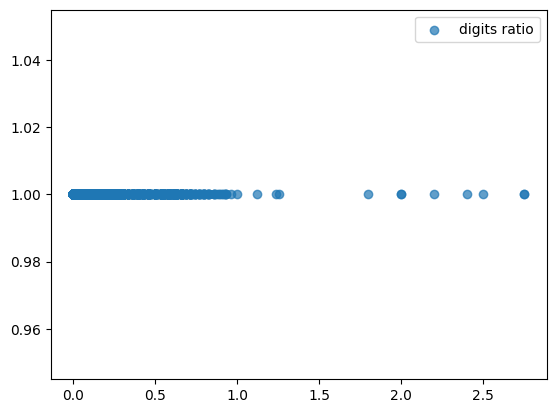

In [ ]:
plt.scatter(phishing_data['D/L_Ratio'], phishing_data['label'], marker='o', label='digits ratio', alpha=0.7)
plt.legend()
plt.show()


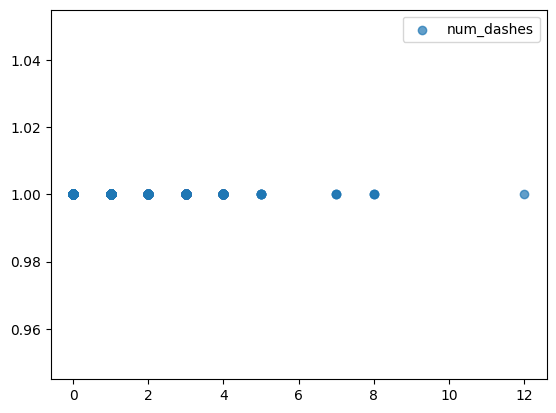

In [ ]:
plt.scatter(phishing_data['NoOf_Dashes'], phishing_data['label'], marker='o', label='num_dashes', alpha=0.7)
plt.legend()
plt.show()

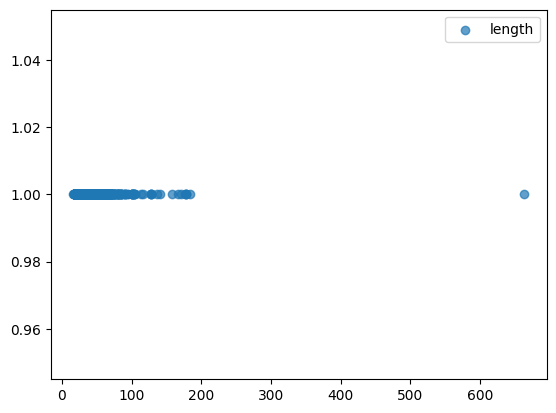

In [ ]:
plt.scatter(phishing_data['length_of_url'], phishing_data['label'], marker='o', label='length', alpha=0.7)
plt.legend()
plt.show()

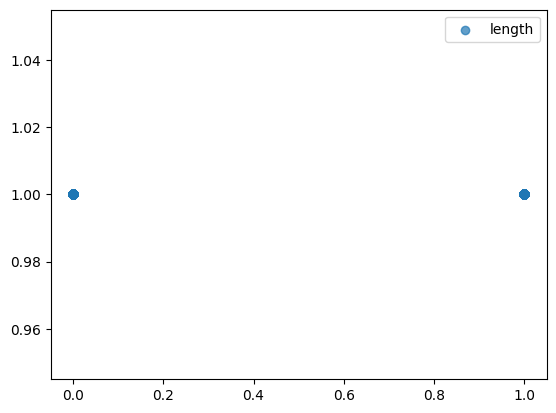

In [ ]:
plt.scatter(phishing_data['PresenceOfDigitsInDomain'], phishing_data['label'], marker='o', label='length', alpha=0.7)
plt.legend()
plt.show()

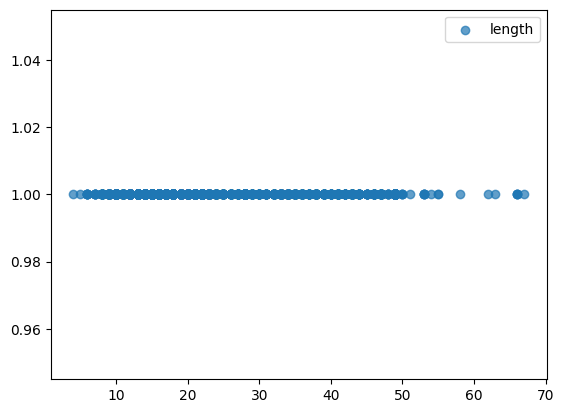

In [ ]:
plt.scatter(phishing_data['Length_of_Hostname'], phishing_data['label'], marker='o', label='length', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
df_2_final['NoOf_Dashes'] = df_2_final['url'].apply(num_dashes)
df_2_final['D/L_Ratio'] = df_2_final['url'].apply(calculate_digit_letter_ratio)
df_2_final['NoOf_TLDs'] = df_2_final['url'].apply(num_TLDs)
df_2_final['length_of_url'] = df_2_final['url'].apply(lambda url:len(url))
df_2_final['PresenceOfDigitsInDomain'] = df_2_final['url'].apply(presence_of_digits_domain)
df_2_final['Multiple_Subdomains'] = df_2_final['url'].apply(has_multiple_subdomains)
df_2_final['Length_of_Hostname'] = df_2_final['url'].apply(hostname_length)
df_2_final['Network_Protocol'] = df_2_final['url'].apply(network_protocol_check)
df_2_final['Digits_in_Subdomain'] = df_2_final['url'].apply(presence_of_nums_in_subdomain)
df_2_final['Shortened'] = df_2_final['url'].apply(is_shortened)
df_2_final['Has_IP_or_Port'] = df_2_final['url'].apply(has_ip_or_port)
df_2_final['URL_Entropy'] = df_2_final['url'].apply(entropy_of_url)
#df_2_final['Domain_Life_in_Days'] = df_2_final['url'].apply(domain_registration_time)

In [ ]:
def plotLearningCurve(model, X_set, y_set):
  train_sizes, train_scores, test_scores = learning_curve(
      model, X_set, y_set, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
  )

  train_mean = np.mean(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)

  plt.plot(train_sizes, train_mean, label='Training Accuracy')
  plt.plot(train_sizes, test_mean, label='Validation Accuracy')
  plt.xlabel('Training Set Size')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
X = url_df.drop(['URL', 'label'], axis=1)
y = url_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_2 = df_2_final.drop(['url', 'type'], axis=1)
y_2 = df_2_final['type']

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=23)

scaler = StandardScaler()
X_2_train_scaled = scaler.fit_transform(X_2_train)
X_2_test_scaled = scaler.transform(X_2_test)

#Logistic Regression

In [ ]:
lg_model = LogisticRegression(random_state=42)
lg_model.fit(X_train_scaled, y_train)

y_pred = lg_model.predict(X_test_scaled)


lr_accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {lr_accuracy}')

Accuracy: 0.8117647058823529


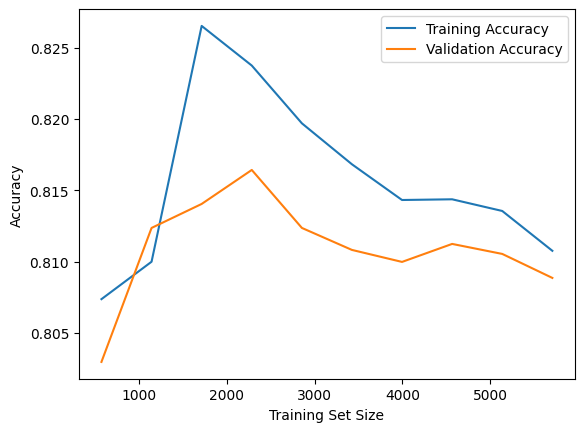

In [ ]:
plotLearningCurve(lg_model,X_train_scaled, y_train)

In [ ]:
pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.5 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from hyperopt import fmin, tpe, hp
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



lg_model = LogisticRegression(random_state=42)

# Manual Search (Adjust hyperparameters manually)
manual_params = {'penalty': 'l2', 'C': 1.0, 'solver': 'liblinear'}
manual_model = LogisticRegression(random_state=42, **manual_params)
manual_model.fit(X_train_scaled, y_train)
y_manual_pred = manual_model.predict(X_test_scaled)
accuracy_manual = accuracy_score(y_test, y_manual_pred)
print(f'Accuracy (Manual Search): {accuracy_manual}')

# Random Search
param_distributions = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga']
}
random_search_model = RandomizedSearchCV(LogisticRegression(random_state=42), param_distributions, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_model.fit(X_train_scaled, y_train)
y_random_pred = random_search_model.predict(X_test_scaled)
accuracy_random = accuracy_score(y_test, y_random_pred)
print(f'Accuracy (Random Search): {accuracy_random}')
print("Best Hyperparameters (Random Search):", random_search_model.best_params_)

# Grid Search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga']
}
grid_search_model = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search_model.fit(X_train_scaled, y_train)
y_grid_pred = grid_search_model.predict(X_test_scaled)
accuracy_grid = accuracy_score(y_test, y_grid_pred)
print(f'Accuracy (Grid Search): {accuracy_grid}')
print("Best Hyperparameters (Grid Search):", grid_search_model.best_params_)

# Bayesian Optimization using scikit-optimize
param_space = {
    'penalty': ['l1', 'l2'],
    'C': (1e-6, 1e+3, 'log-uniform'),
    'solver': ['liblinear', 'saga']
}
opt = BayesSearchCV(LogisticRegression(random_state=42), param_space, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
opt.fit(X_train_scaled, y_train)
best_params_bayesian = opt.best_params_
best_accuracy_bayesian = opt.best_score_
print("Best Hyperparameters (Bayesian Optimization):", best_params_bayesian)
print(f'Accuracy (Bayesian Optimization): {best_accuracy_bayesian}')

# Bayesian Optimization using HyperOpt-Sklearn
space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', -6, 3),
    'solver': hp.choice('solver', ['liblinear', 'saga'])
}

def objective(params):
    model = LogisticRegression(random_state=42, **params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    score = accuracy_score(y_test, y_pred)
    return -score

best_params_hyperopt = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)
print("Best Hyperparameters (HyperOpt-Sklearn):", best_params_hyperopt)



Accuracy (Manual Search): 0.8117647058823529
Accuracy (Random Search): 0.8117647058823529
Best Hyperparameters (Random Search): {'solver': 'saga', 'penalty': 'l1', 'C': 1}
Accuracy (Grid Search): 0.8117647058823529
Best Hyperparameters (Grid Search): {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best Hyperparameters (Bayesian Optimization): OrderedDict([('C', 4.544325970831821), ('penalty', 'l2'), ('solver', 'liblinear')])
Accuracy (Bayesian Optimization): 0.8101181888312438
100%|██████████| 10/10 [00:00<00:00, 17.78trial/s, best loss: -0.8117647058823529]
Best Hyperparameters (HyperOpt-Sklearn): {'C': 0.3133298524654907, 'penalty': 1, 'solver': 0}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning)


X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=23)

scaler = StandardScaler()
X_2_train_scaled = scaler.fit_transform(X_2_train)
X_2_test_scaled = scaler.transform(X_2_test)

# Logistic Regression model
lg_model = LogisticRegression(random_state=42)

# Manual Search
manual_params = {
    'penalty': 'l2',
    'C': 1.0,
    'solver': 'liblinear',
    'max_iter': 1000
}
lg_model.set_params(**manual_params)
lg_model.fit(X_2_train_scaled, y_2_train)
y_manual_pred = lg_model.predict(X_2_test_scaled)
accuracy_manual = accuracy_score(y_2_test, y_manual_pred)
print(f'Accuracy (Manual Search): {accuracy_manual}')
print("Hyperparameters (Manual Search):", manual_params)

# Random Search
param_distributions = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000, 1500]
}
random_search_model = RandomizedSearchCV(lg_model, param_distributions, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_model.fit(X_2_train_scaled, y_2_train)
y_random_pred = random_search_model.predict(X_2_test_scaled)
accuracy_random = accuracy_score(y_2_test, y_random_pred)
print(f'Accuracy (Random Search): {accuracy_random}')
print("Best Hyperparameters (Random Search):", random_search_model.best_params_)

# Grid Search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000, 1500]
}
grid_search_model = GridSearchCV(lg_model, param_grid, cv=5, scoring='accuracy')
grid_search_model.fit(X_2_train_scaled, y_2_train)
y_grid_pred = grid_search_model.predict(X_2_test_scaled)
accuracy_grid = accuracy_score(y_2_test, y_grid_pred)
print(f'Accuracy (Grid Search): {accuracy_grid}')
print("Best Hyperparameters (Grid Search):", grid_search_model.best_params_)

# Bayesian Optimization using scikit-optimize
param_space = {
    'penalty': ['l1', 'l2'],
    'C': (1e-6, 1e+3, 'log-uniform'),
    'solver': ['liblinear', 'saga'],
    'max_iter': (100, 1000)
}
opt = BayesSearchCV(lg_model, param_space, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
opt.fit(X_2_train_scaled, y_2_train)
best_params_bayesian = opt.best_params_
best_accuracy_bayesian = opt.best_score_
print(f'Accuracy (Bayesian Optimization): {best_accuracy_bayesian}')
print("Best Hyperparameters (Bayesian Optimization):", best_params_bayesian)


Accuracy (Manual Search): 0.946414499605989
Hyperparameters (Manual Search): {'penalty': 'l2', 'C': 1.0, 'solver': 'liblinear', 'max_iter': 1000}
Accuracy (Random Search): 0.9456264775413712
Best Hyperparameters (Random Search): {'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'C': 10}
Accuracy (Grid Search): 0.9456264775413712
Best Hyperparameters (Grid Search): {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Accuracy (Bayesian Optimization): 0.9410497371770582
Best Hyperparameters (Bayesian Optimization): OrderedDict([('C', 737.9606042225641), ('max_iter', 676), ('penalty', 'l2'), ('solver', 'liblinear')])


#Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=12)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f'Accuracy: {accuracy_rf}')

Accuracy: 0.8823529411764706


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np



# Define your RandomForestClassifier
rf_model = RandomForestClassifier(random_state=12)

# Manual Search
manual_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}
rf_model_manual = RandomForestClassifier(random_state=12, **manual_params)
rf_model_manual.fit(X_train_scaled, y_train)
y_pred_rf_manual = rf_model_manual.predict(X_test_scaled)
accuracy_rf_manual = accuracy_score(y_test, y_pred_rf_manual)
print(f'Accuracy (Manual Search): {accuracy_rf_manual}')

# Random Search
param_distributions = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search_model = RandomizedSearchCV(RandomForestClassifier(random_state=12), param_distributions, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_model.fit(X_train_scaled, y_train)
y_pred_rf_random = random_search_model.predict(X_test_scaled)
accuracy_rf_random = accuracy_score(y_test, y_pred_rf_random)
print(f'Accuracy (Random Search): {accuracy_rf_random}')

# Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_model = GridSearchCV(RandomForestClassifier(random_state=12), param_grid, cv=5, scoring='accuracy')
grid_search_model.fit(X_train_scaled, y_train)
y_pred_rf_grid = grid_search_model.predict(X_test_scaled)
accuracy_rf_grid = accuracy_score(y_test, y_pred_rf_grid)
print(f'Accuracy (Grid Search): {accuracy_rf_grid}')

# Bayesian Optimization using scikit-optimize
param_space = {
    'n_estimators': (50, 200),
    'max_depth': (1, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}
opt = BayesSearchCV(RandomForestClassifier(random_state=12), param_space, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
opt.fit(X_train_scaled, y_train)
best_params_bayesian = opt.best_params_
y_pred_rf_bayesian = opt.predict(X_test_scaled)
accuracy_rf_bayesian = accuracy_score(y_test, y_pred_rf_bayesian)
print(f'Accuracy (Bayesian Optimization): {accuracy_rf_bayesian}')


Accuracy (Manual Search): 0.8717086834733894
Accuracy (Random Search): 0.8907563025210085
Accuracy (Grid Search): 0.8857142857142857
Accuracy (Bayesian Optimization): 0.8885154061624649


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from hyperopt import fmin, tpe, hp
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)


scaler_2 = StandardScaler()
X_2_train_scaled = scaler_2.fit_transform(X_2_train)
X_2_test_scaled = scaler_2.transform(X_2_test)

# RandomForestClassifier for dataset 2
rf_2_model = RandomForestClassifier(random_state=12)
rf_2_model.fit(X_2_train_scaled, y_2_train)

y_2_pred_rf = rf_2_model.predict(X_2_test_scaled)
accuracy_2_rf = accuracy_score(y_2_test, y_2_pred_rf)
print(f'Accuracy: {accuracy_2_rf}')

# Random Search
param_distributions_2 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search_model_2 = RandomizedSearchCV(RandomForestClassifier(random_state=12), param_distributions_2, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_model_2.fit(X_2_train_scaled, y_2_train)
y_2_pred_rf_random = random_search_model_2.predict(X_2_test_scaled)
accuracy_2_rf_random = accuracy_score(y_2_test, y_2_pred_rf_random)
print(f'Accuracy (Random Search): {accuracy_2_rf_random}')
print("Best Hyperparameters (Random Search):", random_search_model_2.best_params_)

# Grid Search
param_grid_2 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_model_2 = GridSearchCV(RandomForestClassifier(random_state=12), param_grid_2, cv=5, scoring='accuracy')
grid_search_model_2.fit(X_2_train_scaled, y_2_train)
y_2_pred_rf_grid = grid_search_model_2.predict(X_2_test_scaled)
accuracy_2_rf_grid = accuracy_score(y_2_test, y_2_pred_rf_grid)
print(f'Accuracy (Grid Search): {accuracy_2_rf_grid}')
print("Best Hyperparameters (Grid Search):", grid_search_model_2.best_params_)

# Bayesian Optimization using scikit-optimize
param_space_2 = {
    'n_estimators': (50, 200),
    'max_depth': (1, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

opt_2 = BayesSearchCV(RandomForestClassifier(random_state=12), param_space_2, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
opt_2.fit(X_2_train_scaled, y_2_train)
best_params_bayesian_2 = opt_2.best_params_
y_2_pred_rf_bayesian = opt_2.predict(X_2_test_scaled)
accuracy_2_rf_bayesian = accuracy_score(y_2_test, y_2_pred_rf_bayesian)
print(f'Accuracy (Bayesian Optimization): {accuracy_2_rf_bayesian}')
print("Best Hyperparameters (Bayesian Optimization):", best_params_bayesian_2)

# HyperOpt-Sklearn
space_2 = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200]),
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4])
}
def objective_2(params):
    model_2 = RandomForestClassifier(random_state=12, **params)
    model_2.fit(X_2_train_scaled, y_2_train)
    y_2_pred = model_2.predict(X_2_test_scaled)
    score_2 = accuracy_score(y_2_test, y_2_pred)
    return -score_2

best_params_hyperopt_2 = fmin(fn=objective_2, space=space_2, algo=tpe.suggest, max_evals=10)
print("Best Hyperparameters (HyperOpt-Sklearn):", best_params_hyperopt_2)


Accuracy: 0.9479905437352246
Accuracy (Random Search): 0.9519306540583137
Best Hyperparameters (Random Search): {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Accuracy (Grid Search): 0.950354609929078
Best Hyperparameters (Grid Search): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy (Bayesian Optimization): 0.9495665878644602
Best Hyperparameters (Bayesian Optimization): OrderedDict([('max_depth', 14), ('min_samples_leaf', 3), ('min_samples_split', 3), ('n_estimators', 154)])
100%|██████████| 10/10 [00:05<00:00,  1.77trial/s, best loss: -0.9535066981875493]
Best Hyperparameters (HyperOpt-Sklearn): {'max_depth': 2, 'min_samples_leaf': 0, 'min_samples_split': 2, 'n_estimators': 0}


#XG Boost

In [ ]:
xgb_model = XGBClassifier(random_state=5)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f'Accuracy: {accuracy_xgb}')

Accuracy: 0.8834733893557423


In [ ]:
!pip install scikit-optimize


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from hyperopt import fmin, tpe, hp
import random




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
xgb_model = XGBClassifier(random_state=5)

# Manual Search
manual_params_xgb = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'random_state': 5
}
manual_xgb_model = XGBClassifier(**manual_params_xgb)
manual_xgb_model.fit(X_train, y_train)
y_manual_xgb_pred = manual_xgb_model.predict(X_test)
accuracy_manual_xgb = accuracy_score(y_test, y_manual_xgb_pred)
print(f'Accuracy (Manual Search): {accuracy_manual_xgb}')

# TPE (Tree-structured Parzen Estimators)
param_space_xgb_tpe = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9]),
    'subsample': hp.uniform('subsample', 0.6, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.9),
    'gamma': hp.uniform('gamma', 0, 0.4),
    'random_state': 5
}

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy (TPE): {accuracy}')
    return -accuracy

best_params_tpe = fmin(fn=objective,
                      space=param_space_xgb_tpe,
                      algo=tpe.suggest,
                      max_evals=10,
                      rstate=random.seed(5))
print("Best Hyperparameters (TPE):", best_params_tpe)

# Random Search
param_distributions_xgb = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'random_state': [5]
}
random_search_xgb_model = RandomizedSearchCV(XGBClassifier(random_state=5), param_distributions_xgb, n_iter=10, cv=5, scoring='accuracy', random_state=5)
random_search_xgb_model.fit(X_train, y_train)
y_random_xgb_pred = random_search_xgb_model.predict(X_test)
accuracy_random_xgb = accuracy_score(y_test, y_random_xgb_pred)
print(f'Accuracy (Random Search): {accuracy_random_xgb}')
print("Best Hyperparameters (Random Search):", random_search_xgb_model.best_params_)

# Bayesian Optimization
param_space_xgb = {
    'learning_rate': (0.001, 0.3, 'log-uniform'),
    'n_estimators': (50, 300),
    'max_depth': (3, 9),
    'subsample': (0.6, 0.9),
    'colsample_bytree': (0.6, 0.9),
    'gamma': (0, 0.4),
    'random_state': [5]
}
bayesian_search_xgb_model = BayesSearchCV(XGBClassifier(random_state=5), param_space_xgb, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
bayesian_search_xgb_model.fit(X_train, y_train)
best_params_bayesian_xgb = bayesian_search_xgb_model.best_params_
print("Best Hyperparameters (Bayesian Optimization):", best_params_bayesian_xgb)


Accuracy (Manual Search): 0.8745098039215686
Accuracy (TPE): 0.8829131652661064
Accuracy (TPE): 0.8890756302521008
Accuracy (TPE): 0.8862745098039215
Accuracy (TPE): 0.8817927170868347
Accuracy (TPE): 0.8829131652661064
Accuracy (TPE): 0.884593837535014
Accuracy (TPE): 0.8896358543417366
Accuracy (TPE): 0.8885154061624649
Accuracy (TPE): 0.8918767507002802
Accuracy (TPE): 0.8879551820728291
100%|██████████| 10/10 [00:25<00:00,  2.52s/trial, best loss: -0.8918767507002802]
Best Hyperparameters (TPE): {'colsample_bytree': 0.635962378383195, 'gamma': 0.3599131725754541, 'learning_rate': 0.12233765958799774, 'max_depth': 2, 'n_estimators': 105.0, 'subsample': 0.8163721803138035}
Accuracy (Random Search): 0.8890756302521008
Best Hyperparameters (Random Search): {'subsample': 0.8, 'random_state': 5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}
Best Hyperparameters (Bayesian Optimization): OrderedDict([('colsample_bytree', 0.729930610063712

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from hyperopt import fmin, tpe, hp
import random

# Assuming you have df_2_final as the dataset and X, y as features and labels
X_2 = df_2_final.drop(['url', 'type'], axis=1)
y_2 = df_2_final['type']

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=23)

scaler = StandardScaler()
X_2_train_scaled = scaler.fit_transform(X_2_train)
X_2_test_scaled = scaler.transform(X_2_test)

# XGBoost model
xgb_model = XGBClassifier(random_state=5)

# Manual Search
manual_params_xgb = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'random_state': 5
}
manual_xgb_model = XGBClassifier(**manual_params_xgb)
manual_xgb_model.fit(X_2_train_scaled, y_2_train)
y_manual_xgb_pred = manual_xgb_model.predict(X_2_test_scaled)
accuracy_manual_xgb = accuracy_score(y_2_test, y_manual_xgb_pred)
print(f'Accuracy (Manual Search): {accuracy_manual_xgb}')

# Random Search
random_params_xgb = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'random_state': [5]
}
random_search_xgb_model = RandomizedSearchCV(XGBClassifier(random_state=5), param_distributions=random_params_xgb, n_iter=10, cv=5, scoring='accuracy', random_state=5)
random_search_xgb_model.fit(X_2_train_scaled, y_2_train)
y_random_xgb_pred = random_search_xgb_model.predict(X_2_test_scaled)
accuracy_random_xgb = accuracy_score(y_2_test, y_random_xgb_pred)
print(f'Accuracy (Random Search): {accuracy_random_xgb}')
print("Best Hyperparameters (Random Search):", random_search_xgb_model.best_params_)

# Hyperopt Search
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'subsample': hp.uniform('subsample', 0.6, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.9),
    'gamma': hp.uniform('gamma', 0, 0.4),
    'random_state': 5
}
def objective(params):

    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(**params)
    model.fit(X_2_train_scaled, y_2_train)
    y_pred = model.predict(X_2_test_scaled)
    score = accuracy_score(y_2_test, y_pred)
    print(f'Accuracy (Hyperopt): {score}')
    return -score

best_params_hyperopt = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)
print("Best Hyperparameters (Hyperopt):", best_params_hyperopt)

# Bayesian Optimization
bayesian_params_xgb = {
    'learning_rate': (0.001, 0.3, 'log-uniform'),
    'n_estimators': (50, 300),
    'max_depth': (3, 9),
    'subsample': (0.6, 0.9),
    'colsample_bytree': (0.6, 0.9),
    'gamma': (0, 0.4),
    'random_state': [5]
}

bayesian_search_xgb_model = BayesSearchCV(
    XGBClassifier(random_state=5),
    search_spaces=bayesian_params_xgb,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

bayesian_search_xgb_model.fit(X_2_train_scaled, y_2_train)
best_params_bayesian_xgb = bayesian_search_xgb_model.best_params_
print("Best Hyperparameters (Bayesian Optimization):", best_params_bayesian_xgb)


Accuracy (Manual Search): 0.9495665878644602
Accuracy (Random Search): 0.9511426319936959
Best Hyperparameters (Random Search): {'subsample': 0.8, 'random_state': 5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}
Accuracy (Hyperopt): 0.9495665878644602
Accuracy (Hyperopt): 0.950354609929078
Accuracy (Hyperopt): 0.929866036249015
Accuracy (Hyperopt): 0.9519306540583137
Accuracy (Hyperopt): 0.9361702127659575
Accuracy (Hyperopt): 0.9511426319936959
Accuracy (Hyperopt): 0.9511426319936959
Accuracy (Hyperopt): 0.9519306540583137
Accuracy (Hyperopt): 0.9345941686367218
Accuracy (Hyperopt): 0.9393223010244287
100%|██████████| 10/10 [00:01<00:00,  5.95trial/s, best loss: -0.9519306540583137]
Best Hyperparameters (Hyperopt): {'colsample_bytree': 0.6362253020160547, 'gamma': 0.22213132799050223, 'learning_rate': 0.03886261249205942, 'max_depth': 2, 'n_estimators': 268.0, 'subsample': 0.8757458220892255}
Best Hyperparameters (Bayesian Optimizati